#Install and Import Library

In [1002]:
!pip install yfinance

In [1003]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import keras
from datetime import date

In [1004]:
import unittest

#Get Data

In [1005]:
# DATA_PATH = "data_saham.csv"
# data = yf.download("BTC-USD", start="2023-11-01", end="2024-11-10", interval = "1d")
# print(data)
# data.to_csv(DATA_PATH)

DATA_PATH = "data_saham.csv"
date_now = date.today().isoformat()
data = yf.download("INDY.JK", start="2008-08-01", end=date_now, interval = "1wk")
print(data)
data.to_csv(DATA_PATH)

[*********************100%***********************]  1 of 1 completed

Price                        Adj Close   Close    High     Low    Open  \
Ticker                         INDY.JK INDY.JK INDY.JK INDY.JK INDY.JK   
Date                                                                     
2008-07-28 00:00:00+00:00  1676.611816  3075.0  3100.0  3000.0  3075.0   
2008-08-04 00:00:00+00:00  1581.195312  2900.0  3025.0  2800.0  3000.0   
2008-08-11 00:00:00+00:00  1376.730347  2525.0  2850.0  2350.0  2850.0   
2008-08-18 00:00:00+00:00  1513.040039  2775.0  2850.0  2450.0  2525.0   
2008-08-25 00:00:00+00:00  1540.302246  2825.0  2825.0  2625.0  2675.0   
...                                ...     ...     ...     ...     ...   
2024-10-21 00:00:00+00:00  1650.000000  1650.0  1725.0  1650.0  1720.0   
2024-10-28 00:00:00+00:00  1505.000000  1505.0  1660.0  1500.0  1645.0   
2024-11-04 00:00:00+00:00  1470.000000  1470.0  1620.0  1460.0  1505.0   
2024-11-11 00:00:00+00:00  1425.000000  1425.0  1595.0  1410.0  1480.0   
2024-11-18 00:00:00+00:00  1415.000000

In [1006]:
def parse_data_from_file(filename):
  # Load the file, skipping the first three rows to remove unnecessary headers
  data = pd.read_csv('data_saham.csv', skiprows=[1,2])

  # Rename price column to date
  data.rename(columns={'Price': 'Date'}, inplace=True)

  # Convert the 'Date' column to datetime format
  data['Date'] = pd.to_datetime(data['Date'])

  # Set 'Date' as the index
  data.set_index('Date', inplace=True)

  # Select only the 'Adj Close' column for forecasting
  data = data[['Adj Close']]

  data.head()

  dates = data.index.tolist()
  adj_closes = data['Adj Close'].tolist()

  return np.array(dates), np.array(adj_closes)

In [1007]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

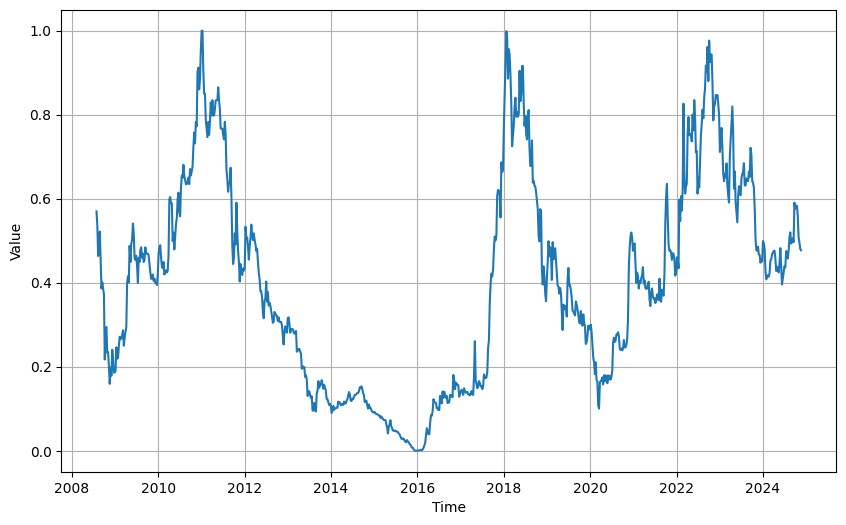

In [1008]:
TIME, SERIES = parse_data_from_file(DATA_PATH)

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the series data
SERIES = scaler.fit_transform(SERIES.reshape(-1, 1)).flatten()

# Plot the series!
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)

#Global Variable

In [1009]:
# Save all global variables
SPLIT_TRAIN = int(len(SERIES) * 0.7)
SPLIT_VALID = int(len(SERIES) * 0.8)
WINDOW_SIZE = 4
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000

#Train Data

In [1010]:
#Split data train and validation
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TRAIN]
    series_train = series[:SPLIT_TRAIN]

    time_valid = time[SPLIT_TRAIN:SPLIT_VALID]
    series_valid = series[SPLIT_TRAIN:SPLIT_VALID]

    time_test = time[SPLIT_VALID:]
    series_test = series[SPLIT_VALID:]

    return time_train, series_train, time_valid, series_valid, time_test, series_test

In [1011]:
time_train, series_train, time_valid, series_valid, time_test, series_test = train_val_split(TIME, SERIES)

In [1012]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

In [1013]:
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)
valid_dataset = windowed_dataset(series_valid, window_size=WINDOW_SIZE)
test_dataset = windowed_dataset(series_test, window_size=WINDOW_SIZE)

#Defining the model architecture


In [1014]:
# def create_uncompiled_model():
#     """Define uncompiled model

#     Returns:
#         tf.keras.Model: uncompiled model
#     """

#     model = tf.keras.models.Sequential([
#         tf.keras.Input(shape=(None, 1)),
#         tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='causal'),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128)),
#         tf.keras.layers.Dense(1),
#         tf.keras.layers.Lambda(lambda x: x * 200)
#     ])

#     return model

In [1015]:
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(None, 1)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 200)
    ])

    return model

In [1016]:
uncompiled_model = create_uncompiled_model()

In [1017]:
example_batch = train_dataset.take(1)

In [1018]:
try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (16, 1)


In [1019]:
uncompiled_model.summary()

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)                   │ (None, None, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_96 (Bidirectional)     │ (None, None, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_97 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_48 (Lambda)                   │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,249 (645.50 KB)

 Trainable params: 165,249 (645.50 KB)

 Non-trainable params: 0 (0.00 B)

#Adjust Learning Rate

In [1020]:
# def adjust_learning_rate(dataset):
#     """Fit model using different learning rates."""
#     model = create_uncompiled_model()

#     lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

#     # Compile the model
#     model.compile(
#         loss='mse',
#         optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#         metrics=["mse"]
#     )


#     # Fit the model
#     history = model.fit(dataset, validation_data = valid_dataset, epochs=30, callbacks=[lr_schedule])
#     return history

In [1021]:
# lr_history = adjust_learning_rate(train_dataset)

# plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])

#Create Model

In [1022]:
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """

    model = create_uncompiled_model()

    model.compile(loss='huber',
                  optimizer='adam',
                  metrics=["mae", "mse"])

    return model

In [1023]:
# Instantiate and train the model with early stopping
model = create_model()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_dataset, validation_data = valid_dataset, epochs=50, callbacks=[early_stopping])

# Output the model summary and training history (loss per epoch)
model.summary(), history.history['loss'][:10]

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 1.2811 - mae: 1.6877 - mse: 5.5656 - val_loss: 0.0303 - val_mae: 0.2402 - val_mse: 0.0606
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0158 - mae: 0.1430 - mse: 0.0316 - val_loss: 0.0013 - val_mae: 0.0382 - val_mse: 0.0025
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - mae: 0.0345 - mse: 0.0023 - val_loss: 0.0014 - val_mae: 0.0465 - val_mse: 0.0028
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - mae: 0.0351 - mse: 0.0021 - val_loss: 6.0854e-04 - val_mae: 0.0247 - val_mse: 0.0012
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0378 - mse: 0.0026 - val_loss: 6.3316e-04 - val_mae: 0.0275 - val_mse: 0.0013
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - mae: 0.0340 - mse: 0.0022 - val_loss: 7.1478e-04 - val_mae: 0.0289 - val_mse: 0.0014
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - mae: 0.0360 - mse: 0.0022

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_49 (Conv1D)                   │ (None, None, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_98 (Bidirectional)     │ (None, None, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_99 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_49 (Lambda)                   │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,749 (1.89 MB)

 Trainable params: 165,249 (645.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 330,500 (1.26 MB)

(None,
 [0.581792950630188,
  0.009472082369029522,
  0.0012234700843691826,
  0.0009209958952851593,
  0.0010319381253793836,
  0.0011406150879338384,
  0.0010940709616988897,
  0.002935202792286873,
  0.0009946960490196943,
  0.001024420140311122])

In [1024]:
# Plot the training loss for each epoch
loss = history.history['loss']
# loss = best_validation_loss
epochs = range(len(loss))

In [1025]:
# Evaluasi akhir model pada test set
train_loss = model.evaluate(train_dataset)
print("Train Loss:", train_loss)

# Evaluasi akhir model pada test set
valid_loss = model.evaluate(valid_dataset)
print("Valid Loss:", valid_loss)

# Evaluasi akhir model pada test set
test_loss = model.evaluate(test_dataset)
print("Test Loss:", test_loss)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9679e-04 - mae: 0.0247 - mse: 0.0012
Train Loss: [0.0006175736198201776, 0.025070304051041603, 0.0012351472396403551]
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4961e-04 - mae: 0.0213 - mse: 8.9921e-04
Valid Loss: [0.0003910003579221666, 0.02023347280919552, 0.0007820007158443332]
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - mae: 0.0350 - mse: 0.0024
Test Loss: [0.0012410986237227917, 0.03521708399057388, 0.0024821972474455833]


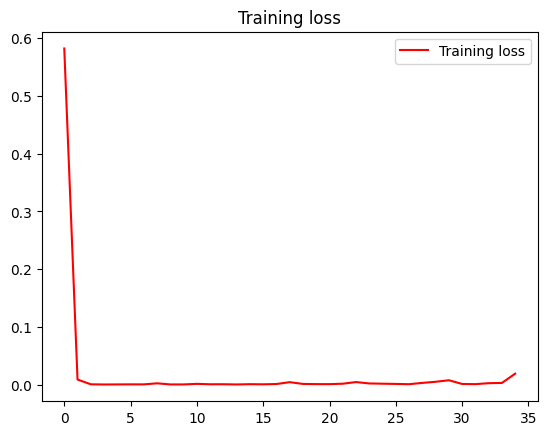

In [1026]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

#Evaluate Forecast & Model Forecast

In [1027]:
"""## Evaluating the forecast"""
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

In [1028]:
"""## Faster Model Forecasts"""
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [1029]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
# rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()
# rnn_forecast = model_forecast(model, SCALED_FEATURE_DATA[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

In [1030]:
# # Plot the forecast
# plt.figure(figsize=(10, 6))
# plot_series(time_valid, series_valid)
# plot_series(time_valid, rnn_forecast)

#TESTING AND PLOTTING USING BOTH VALID AND TEST SET (IF AVAILABLE)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step


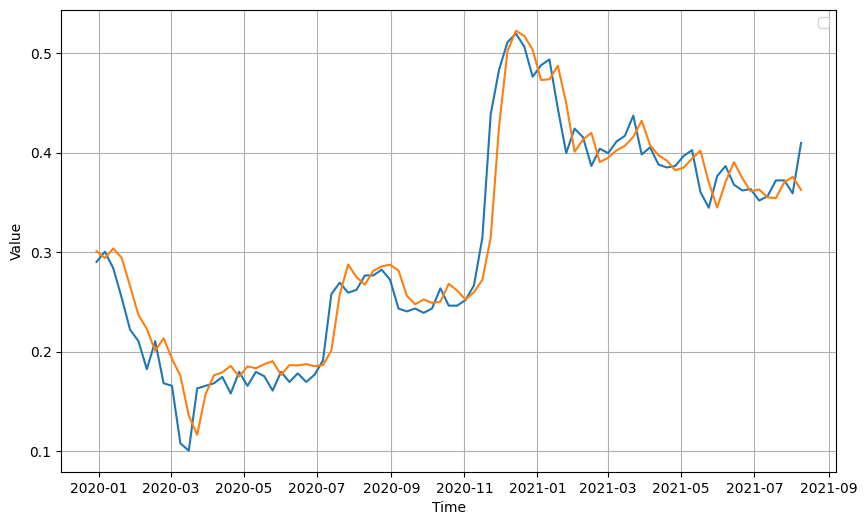

In [1031]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_valid = model_forecast(model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_valid = rnn_forecast_valid[:len(time_valid)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast_valid)
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


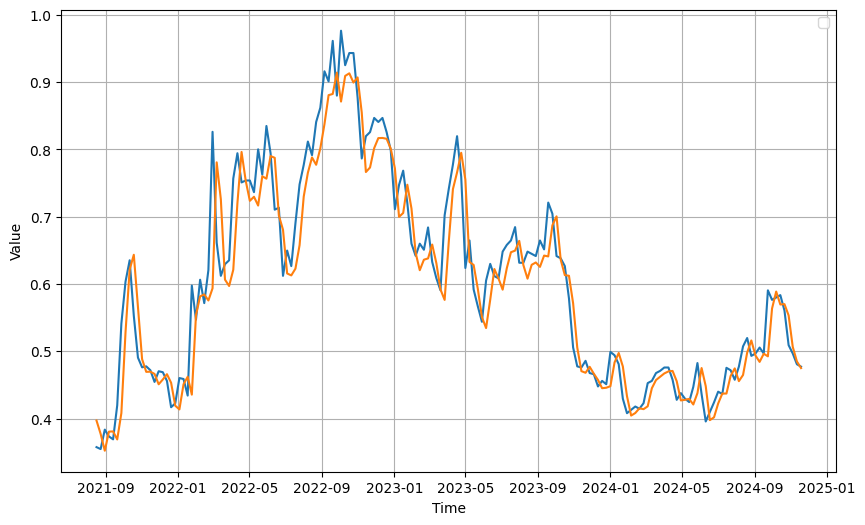

In [1032]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_test = model_forecast(model, SERIES[SPLIT_VALID - WINDOW_SIZE:], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_test = rnn_forecast_test[:len(time_test)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, rnn_forecast_test)
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


256
256


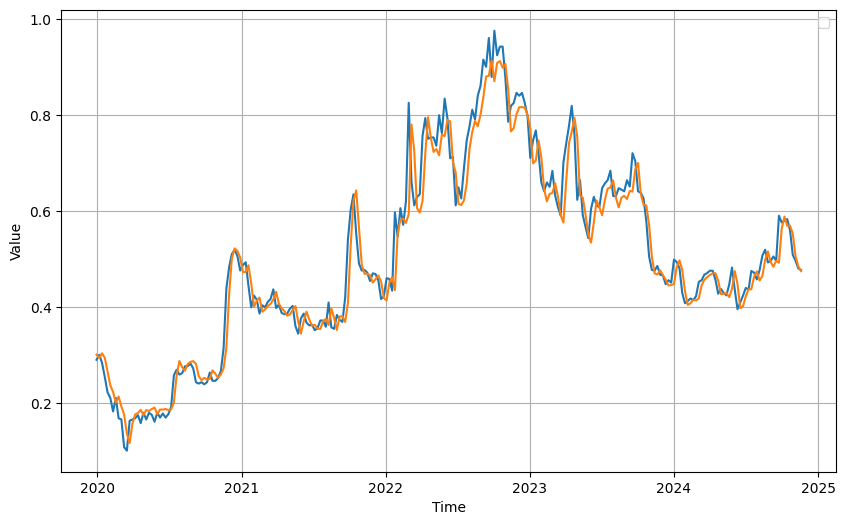

In [1033]:
# Gunakan hanya data untuk test set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_combined = model_forecast(model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID + len(series_test)], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_test sama dengan time_test
rnn_forecast_combined = rnn_forecast_combined[:len(time_valid) + len(time_test)]

print(np.concatenate([time_valid,time_test]).size)
print(rnn_forecast_combined.size)

# Plot the test forecast
plt.figure(figsize=(10, 6))
plot_series(np.concatenate([time_valid,time_test]), np.concatenate([series_valid, series_test]))
plot_series(np.concatenate([time_valid,time_test]), rnn_forecast_combined)
plt.legend()
plt.show()


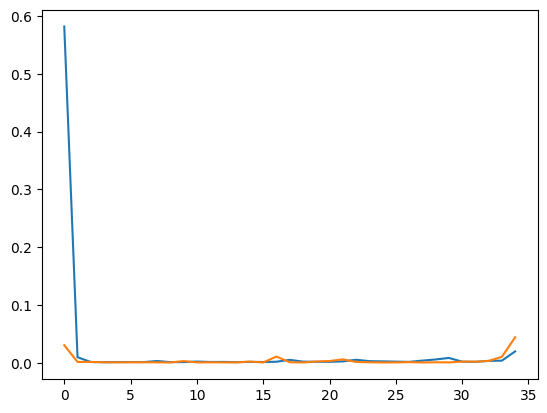

In [1034]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


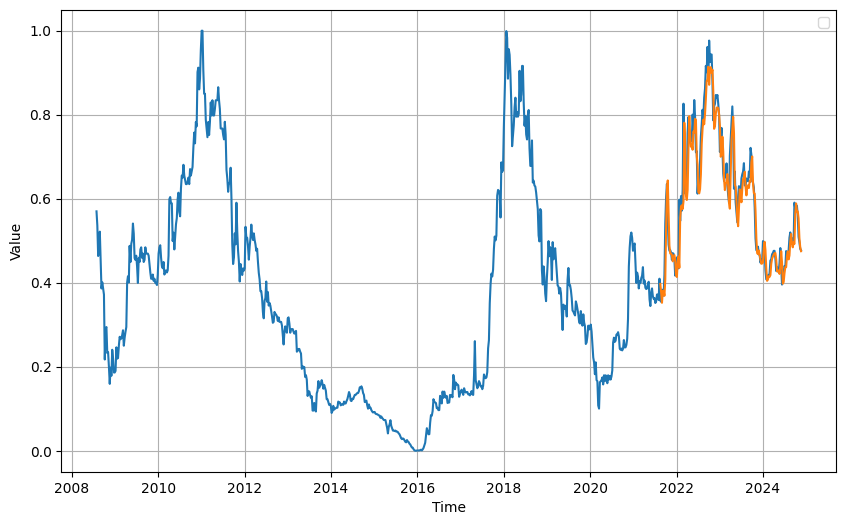

In [1035]:
# Gunakan hanya data untuk test set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_test = model_forecast(model, SERIES[SPLIT_VALID - WINDOW_SIZE:], WINDOW_SIZE).squeeze()
rnn_forecast_test = rnn_forecast_test[:len(time_test)]

time_full = np.concatenate([time_train, time_valid, time_test])
series_full = np.concatenate([series_train, series_valid, series_test])

# Plot the test forecast
plt.figure(figsize=(10, 6))
plot_series(time_full, series_full)
plot_series(time_test, rnn_forecast_test)
plt.legend()
plt.show()

#MAE & MSE EVALUATION

In [1036]:
mse, mae = compute_metrics(series_test    , rnn_forecast_test)

print(f"mse: {mse:.5f}, mae: {mae:.5f} for forecast")

mse: 0.00244, mae: 0.03498 for forecast


#Forecast The Future Series

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

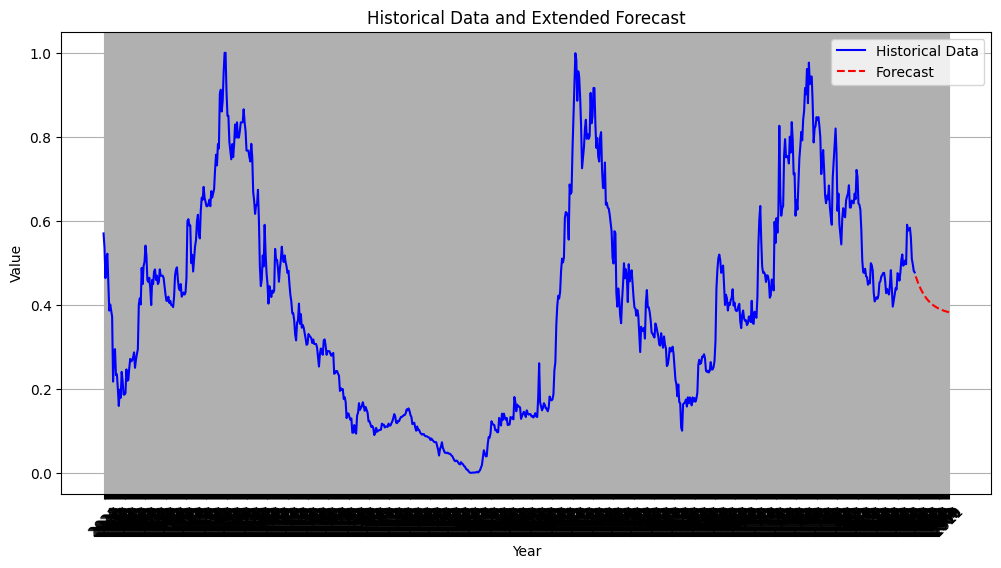

In [1037]:
import numpy as np
import matplotlib.pyplot as plt

def extended_forecast(model, series, window_size, forecast_steps):
    """
    Generates a forecast using your trained model up to a specified number of future steps.
    """
    # Initialize forecast results with the original series to begin prediction
    forecast = list(series[-window_size:])  # Start from the last known window

    for _ in range(forecast_steps):
        # Convert forecast list to tensor
        input_series = np.array(forecast[-window_size:]).reshape(1, -1)  # Shape (1, window_size)

        # Predict the next step
        next_step = model.predict(input_series)[0][0]  # Get the predicted value

        # Append the next step to the forecast
        forecast.append(next_step)

    # Return only the future forecasted steps
    return np.array(forecast[-forecast_steps:])

def plot_extended_forecast(model, series, window_size, forecast_steps, start_year):
    """
    Generates a forecast using your trained model up to a specified number of future steps
    and plots it along with the original series.
    """
    # Generate extended forecast
    forecast = extended_forecast(model, series, window_size, forecast_steps)

    # Define years for plotting
    historical_years = np.arange(start_year, start_year + len(series))
    future_years = np.arange(start_year + len(series), start_year + len(series) + forecast_steps)

    # Plot historical data and forecast
    plt.figure(figsize=(12, 6))
    plt.plot(historical_years, series, label="Historical Data", color="blue")
    plt.plot(future_years, forecast, label="Forecast", color="red", linestyle="--")

    # Adjust x-axis ticks for years
    tick_years = np.concatenate((historical_years, future_years))
    plt.xticks(tick_years, [str(year) for year in tick_years], rotation=45)

    # Add labels and legend
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title("Historical Data and Extended Forecast")
    plt.legend()
    plt.grid(True)
    plt.show()

# Contoh pemanggilan fungsi plot dengan input yang disesuaikan
start_year = 2024  # Tahun pertama data historis
forecast_steps = 36  # Jumlah tahun yang ingin diprediksi (2025-2030)

plot_extended_forecast(model, SERIES, WINDOW_SIZE, forecast_steps, start_year)

In [1038]:
predicted_values = extended_forecast(model, SERIES, WINDOW_SIZE, forecast_steps=6)
print(predicted_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[0.46776608 0.4621004  0.4553798  0.44979    0.4443204  0.43937555]


#Save and Load Model

In [1039]:
model.save('model_saham.h5')
keras.saving.save_model(model, 'my_model.keras')

In [1040]:
new_model = tf.keras.models.load_model('my_model.keras', safe_mode=False)

# # Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
# rnn_forecast = model_forecast(new_model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()
# # rnn_forecast = model_forecast(model, SCALED_FEATURE_DATA[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

# # Plot the forecast
# plt.figure(figsize=(10, 6))
# plot_series(time_valid, series_valid)
# plot_series(time_valid, rnn_forecast)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


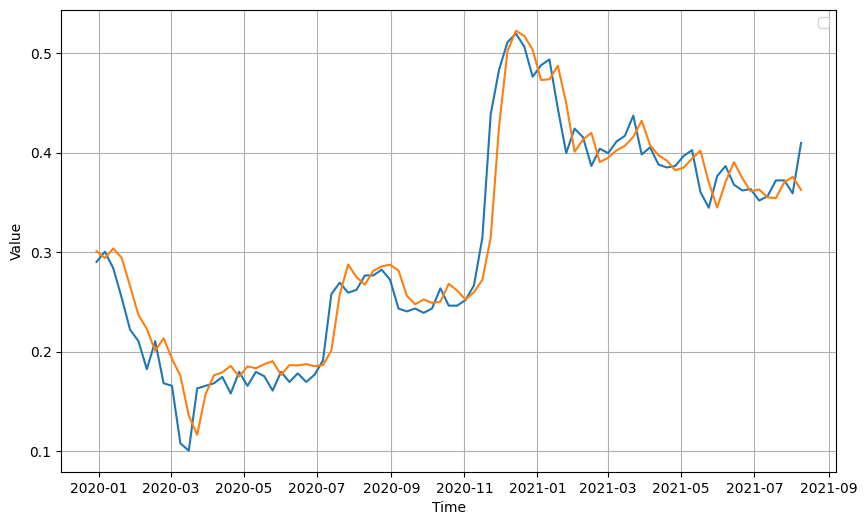

In [1041]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_valid = model_forecast(new_model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_valid = rnn_forecast_valid[:len(time_valid)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast_valid)
plt.legend()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


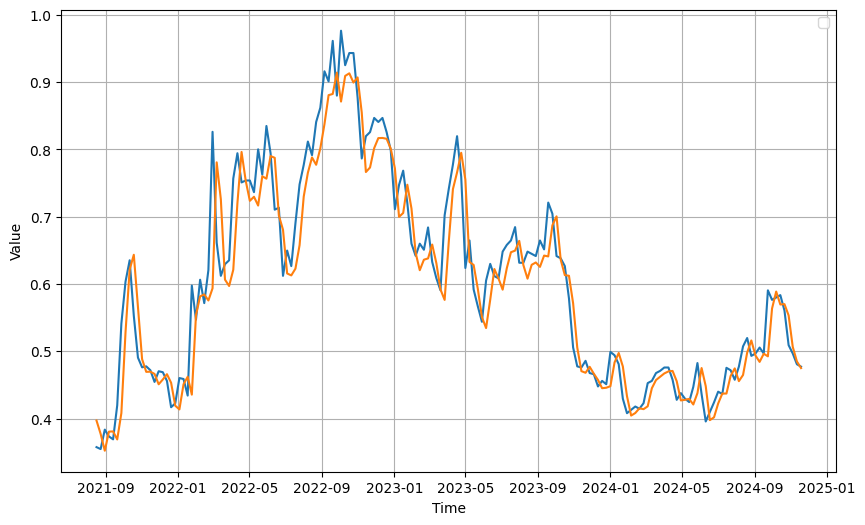

In [1042]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_test = model_forecast(model, SERIES[SPLIT_VALID - WINDOW_SIZE:], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_test = rnn_forecast_test[:len(time_test)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, rnn_forecast_test)
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


256
256


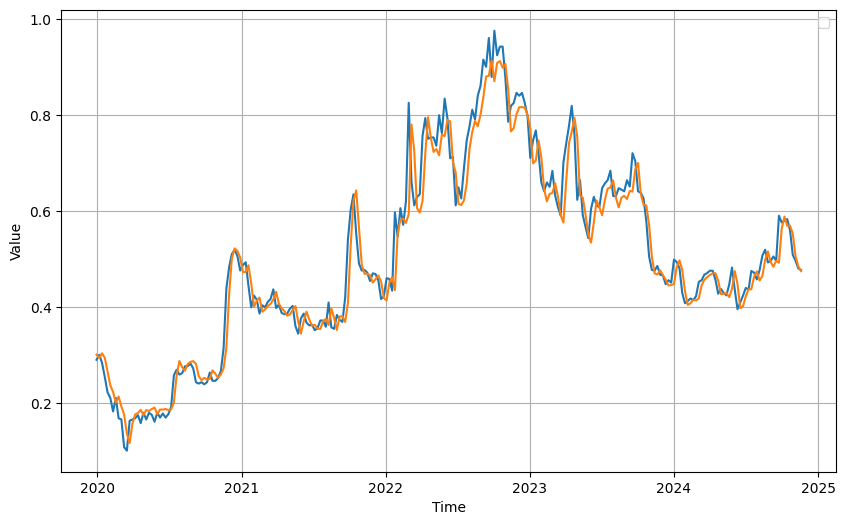

In [1043]:
# Gunakan hanya data untuk test set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_combined = model_forecast(model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID + len(series_test)], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_test sama dengan time_test
rnn_forecast_combined = rnn_forecast_combined[:len(time_valid) + len(time_test)]

print(np.concatenate([time_valid,time_test]).size)
print(rnn_forecast_combined.size)

# Plot the test forecast
plt.figure(figsize=(10, 6))
plot_series(np.concatenate([time_valid,time_test]), np.concatenate([series_valid, series_test]))
plot_series(np.concatenate([time_valid,time_test]), rnn_forecast_combined)
plt.legend()
plt.show()

In [1044]:
config = model.get_config()
print(config)

{'name': 'sequential_49', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, None, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_49'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d_49', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 64, 'kernel_size': (3,), 'strides': (1,), 'padding': 'causal', 'data_format': 'channels_last', 'dilation_rate': (1,), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_na